This notebook uses trained models and makes plots/videos of the predictions.
<span style="color:red;font-weight:bold"> Todo: clean up code. </span>

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import pickle
from keras.utils import to_categorical

from pkl_reader import *
from lstm_impl import CombinedLSTM
from kf_impl import EKF_CV_MODEL
from cnn_lstm_impl import CombinedCNNLSTM
from utils import sup_plot, extract_data, get_parking_lot_image_hist, generate_movie

from tfrecord_utils import write_tfrecord

from PIL import Image, ImageDraw, ImageFont
import traceback

from evaluation_metrics import min_dist_by_timestep

Using TensorFlow backend.


In [2]:
def pkl2tf(file):
    prune_start=True          # remove stationary portion of ego's trajectory at the start
    prune_end=True            # remove stationary portion of ego's trajectory at the end
    min_vel_thresh=0.01       # velocity threshold (m/s) above which ego is considered moving
    exclude_collisions=True  # return an empty trajectory if there was a collision

    Nhist=5          # number of timesteps of motion history to predict with
    Npred=20         # number of timesteps of prediction horizon
    Nskip=5          # "stride" for sliding window of snippet selection
    dt=0.1           # discretization (s) of full ego trajectory corresponding to N* above
    ego_trans = True # whether or not to represent trajectory snippets in the ego frame
                     # if False, use the global map frame for all snippets
    
    
    # full dataset for all files_to_process\
    save_ext = 'pkl'
    features_combined = []
    features_global_combined = []
    labels_combined = []
    goal_snpts_combined = []
    static_objs_combined = []

    parking_lot = None
    ego_dims    = None
    
    if save_ext == 'pkl':
        res_dict = pickle.load(open(file,'rb'))
    else:
        raise NotImplemented('Invalid Extension')
    
    goals = extract_goals(res_dict)
    parking_lot = res_dict['parking_lot']
    ego_dims = res_dict['ego_dimensions']
    
    try:
        assert goals.shape[0] == 32, "Invalid goal shape."
        assert len(res_dict['vehicle_object_lists'][0]) == 56, "Wrong number of static vehicles."
        
        # parse one demonstration
        ego_trajectory, start_ind, switch_ind, end_ind, goal_ind = \
             extract_full_trajectory(res_dict, goals, prune_start, prune_end, \
                                     min_vel_thresh, exclude_collisions)

        features, features_global, labels, labels_global, goal_snpts = \
            get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, \
                                           goals, Nhist, Npred, Nskip, dt, ego_frame=ego_trans)
        
        features_combined.extend(features)
        features_global_combined.extend(features_global)
        labels_combined.extend(labels)
        goal_snpts_combined.extend(goal_snpts)
        
        static_object_list = res_dict['static_object_list']
        for i in range(len(features)):
            static_objs_combined.append(static_object_list)
    except Exception as e:
        print(file, e)
        traceback.print_exc()
        return None, None, None, None, None, None

    num_features = len(features_global_combined)

    img_hists_batch = np.array(
        [get_parking_lot_image_hist(parking_lot, 
                                    static_objs_combined[k], 
                                    features_global_combined[k], 
                                    ego_dims, resize_factor=0.5) for k in range(len(static_objs_combined))])
    
    file_location = file[:-4] + '.tfrecord'

    print('Saving to ', file_location)

    write_tfrecord(features_combined,
                   img_hists_batch,
                   labels_combined, 
                   goal_snpts_combined,
                   file_location, {})
    
    return parking_lot, static_object_list, features_global, labels_global, goal_snpts, ego_trajectory

In [3]:
save_ext = 'pkl'
file_prefix = '../examples/bags/'
search_str = file_prefix + '*.' + save_ext 
files_to_process = glob.glob(search_str)
print('Found %d files to read: %s' % (len(files_to_process), files_to_process))

Found 10 files to read: ['../examples/bags/parking_p10_t6_e8_2020-01-13-15-12-15.pkl', '../examples/bags/parking_p13_t6_e1_2020-01-15-10-23-06.pkl', '../examples/bags/parking_p13_t6_e2_2020-01-15-10-23-25.pkl', '../examples/bags/parking_p13_t6_e3_2020-01-15-10-23-49.pkl', '../examples/bags/parking_p13_t6_e4_2020-01-15-10-24-04.pkl', '../examples/bags/parking_p13_t6_e5_2020-01-15-10-24-19.pkl', '../examples/bags/parking_p13_t6_e6_2020-01-15-10-24-42.pkl', '../examples/bags/parking_p13_t6_e7_2020-01-15-10-25-05.pkl', '../examples/bags/parking_p13_t6_e8_2020-01-15-10-25-23.pkl', '../examples/bags/parking_p13_t6_e9_2020-01-15-10-25-51.pkl']


In [4]:
# Create the model

history_shape       = (5, 3)         # pose history: history horizon of 5, pose dim of 3
image_input_shape   = (5,325,100,3)  # image history: history horizon of 5, image is 325x100x3
goal_position_shape = (32*3,)         # occupancy info: 32 spots x (x,y,is_free) flattened
one_hot_goal_shape  = (32+1,)         # intent prediction dim: 32 spots + 1 "undetermined" category
future_shape        = (20, 2)        # position future: future horizon of 20, xy position dim of 2

hidden_dim = 100                     # hidden dimension for LSTM 
top_k_goal = [0,1,2]                 # specify which trajectory rollouts to predict for multimodal predictions
                                     # (i.e. 0 = most probable intent, 1 = second-most probable intent, etc.)

gamma = 1.0
beta  = 1.0

models = {}

for model_name in ["EKF_CV", "LSTM", "CNN"]:
    if model_name == "EKF_CV":
        model = EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)
        h5files_to_process = glob.glob('./models/EKF*.pkl')
        filename = "./models/EKF_CV_fold4.pkl"
    elif model_name == "LSTM":    
        model = CombinedLSTM(history_shape,
                             goal_position_shape,
                             one_hot_goal_shape,
                             future_shape,
                             hidden_dim,
                             beta=beta,
                             gamma=gamma,
                             use_goal_info=True)
        h5files_to_process = glob.glob('./models/LSTM*.h5')
        filename = "./models/LSTM_b1.000_g1.000_fold4"
    elif model_name == "CNN":
        model = CombinedCNNLSTM(history_shape,
                                 goal_position_shape,
                                 image_input_shape,
                                 one_hot_goal_shape,
                                 future_shape,
                                 hidden_dim,
                                 beta=beta,
                                 gamma=gamma,
                                 use_goal_info=True)
        h5files_to_process = glob.glob('./models/CNN*.h5')
        filename = "./models/CNN_b1.000_g1.000_fold4"
    
    print(model_name + ': Found %d model files: %s' % (len(h5files_to_process), h5files_to_process))
    model.load(filename)
    models[model_name] = model
    print(model_name + ': Load Successfully')

EKF_CV: Found 1 model files: ['./models/EKF_CV_fold4.pkl']
EKF_CV: Load Successfully
LSTM: Found 2 model files: ['./models/LSTM_b1.000_g1.000_fold4_goalw.h5', './models/LSTM_b1.000_g1.000_fold4_trajw.h5']
LSTM: Load Successfully
CNN: Found 2 model files: ['./models/CNN_b1.000_g1.000_fold4_goalcnnw.h5', './models/CNN_b1.000_g1.000_fold4_trajcnnw.h5']
CNN: Load Successfully


In [5]:
pkl2tf_info = []

for filenum in range(len(files_to_process)):
    print("Processing file:", files_to_process[filenum])
    parking_lot, static_object_list, features_global, labels_global, goal_snpts, ego_trajectory = pkl2tf(files_to_process[filenum])
    
    if parking_lot is not None:
        info = {}
        info["parking_lot"] = parking_lot
        info["static_object_list"] = static_object_list
        info["features_global"] = features_global
        info["labels_global"] = labels_global
        info["goal_snpts"] = goal_snpts
        info["ego_trajectory"] = ego_trajectory
        pkl2tf_info.append(info)

Processing file: ../examples/bags/parking_p10_t6_e8_2020-01-13-15-12-15.pkl
Saving to  ../examples/bags/parking_p10_t6_e8_2020-01-13-15-12-15.tfrecord
Processing file: ../examples/bags/parking_p13_t6_e1_2020-01-15-10-23-06.pkl
Saving to  ../examples/bags/parking_p13_t6_e1_2020-01-15-10-23-06.tfrecord
Processing file: ../examples/bags/parking_p13_t6_e2_2020-01-15-10-23-25.pkl
Saving to  ../examples/bags/parking_p13_t6_e2_2020-01-15-10-23-25.tfrecord
Processing file: ../examples/bags/parking_p13_t6_e3_2020-01-15-10-23-49.pkl
Saving to  ../examples/bags/parking_p13_t6_e3_2020-01-15-10-23-49.tfrecord
Processing file: ../examples/bags/parking_p13_t6_e4_2020-01-15-10-24-04.pkl
Saving to  ../examples/bags/parking_p13_t6_e4_2020-01-15-10-24-04.tfrecord
Processing file: ../examples/bags/parking_p13_t6_e5_2020-01-15-10-24-19.pkl
Saving to  ../examples/bags/parking_p13_t6_e5_2020-01-15-10-24-19.tfrecord
Processing file: ../examples/bags/parking_p13_t6_e6_2020-01-15-10-24-42.pkl
Saving to  ../exam

Traceback (most recent call last):
  File "<ipython-input-2-8c7e3132d494>", line 42, in pkl2tf
    min_vel_thresh, exclude_collisions)
  File "/home/xushen/carla/PythonAPI/analysis/pkl_reader.py", line 169, in extract_full_trajectory
    switch_ind = [n for n,intent in enumerate(ego_intent) if intent > -1][0]
IndexError: list index out of range


Saving to  ../examples/bags/parking_p13_t6_e9_2020-01-15-10-25-51.tfrecord


In [6]:
# Get the predict data
tf_to_process = glob.glob('../examples/bags/*.tfrecord')
tf_to_process.sort()
print('Found %d tfrecord files: %s' % (len(tf_to_process), tf_to_process))

Found 9 tfrecord files: ['../examples/bags/parking_p10_t6_e8_2020-01-13-15-12-15.tfrecord', '../examples/bags/parking_p13_t6_e1_2020-01-15-10-23-06.tfrecord', '../examples/bags/parking_p13_t6_e2_2020-01-15-10-23-25.tfrecord', '../examples/bags/parking_p13_t6_e3_2020-01-15-10-23-49.tfrecord', '../examples/bags/parking_p13_t6_e4_2020-01-15-10-24-04.tfrecord', '../examples/bags/parking_p13_t6_e5_2020-01-15-10-24-19.tfrecord', '../examples/bags/parking_p13_t6_e6_2020-01-15-10-24-42.tfrecord', '../examples/bags/parking_p13_t6_e7_2020-01-15-10-25-05.tfrecord', '../examples/bags/parking_p13_t6_e9_2020-01-15-10-25-51.tfrecord']


In [13]:
# To store and compare the trajectories with min and max ade
min_traj_dict = {"case_name": None, "value":  np.inf}
max_traj_dict = {"case_name": None, "value": -np.inf}
min_mmade = {"EKF_CV": min_traj_dict.copy(), "LSTM": min_traj_dict.copy(), "CNN": min_traj_dict.copy()}
max_mmade = {"EKF_CV": max_traj_dict.copy(), "LSTM": max_traj_dict.copy(), "CNN": max_traj_dict.copy()}

save_ext = 'png'

for filenum in range(len(tf_to_process)):
    print("\n======= Processing tfrecord: " + tf_to_process[filenum] + " =========")
    case_name = "_".join(tf_to_process[filenum].split("_")[1:4])
    extreme_case = False
    
    parking_lot        = pkl2tf_info[filenum]["parking_lot"]
    static_object_list = pkl2tf_info[filenum]["static_object_list"]
    features_global    = pkl2tf_info[filenum]["features_global"]
    labels_global      = pkl2tf_info[filenum]["labels_global"]
    goal_snpts         = pkl2tf_info[filenum]["goal_snpts"]
    ego_trajectory     = pkl2tf_info[filenum]["ego_trajectory"]
    
    top_k_goal = [0,1,2]
    for model_name in ["EKF_CV", "LSTM", "CNN"]:
        if model_name == "EKF_CV":
            goal_pred, goal_gt, traj_pred_dict, traj_gt = models[model_name].predict(tf_to_process[filenum])
        else:
            goal_pred, goal_gt, traj_pred_dict, traj_gt = models[model_name].predict(tf_to_process[filenum], top_k_goal)
            
        instance_name = model_name + "_" + case_name
        generate_movie(instance_name, parking_lot, static_object_list, 
                       traj_pred_dict, features_global, labels_global, goal_pred, goal_gt, goal_snpts, top_k_goal, movie=False)
        
        _, mmade = min_dist_by_timestep(traj_pred_dict, traj_gt[:,:,:2])
        
        # If this trajectory is an extreme case for any model, set the flag to be true to keep it
        if mmade > max_mmade[model_name]["value"]:
            max_mmade[model_name]["value"]     = mmade
            max_mmade[model_name]["case_name"] = case_name
            extreme_case = True
            
        if mmade < min_mmade[model_name]["value"]:
            min_mmade[model_name]["value"]     = mmade
            min_mmade[model_name]["case_name"] = case_name
            extreme_case = True
            
#     print("min_mmade", min_mmade)
#     print("max_mmade", max_mmade)
    # If the flag is false -> this is not an extreme case for any model, don't generate movie for this traj
    if not extreme_case:
        for model_name in ["EKF_CV", "LSTM", "CNN"]:
            file_prefix = './figures/' + model_name + "_" + case_name
            os.system("rm -rf %s" % file_prefix)
            
        # !! Jump to the next trajectory
        continue
    
    files_to_process = {}
    num_frame = 0
    
    for model_name in ["EKF_CV", "LSTM", "CNN"]:
        file_prefix = './figures/' + model_name + "_" + case_name
        search_str = file_prefix + '/*.' + save_ext
        files_to_process[model_name] = glob.glob(search_str)
        num_frame = len(glob.glob(search_str))

    # print(files_to_process)
    crop_points = (180, 250, 635, 1700)

    directory = './figures/all_' + case_name
    if not os.path.exists(directory):
        os.mkdir(directory)

    # fonts_path = os.path.join(os.path.dirname(os.path.dirname(__file__)), 'fonts')
    # font = ImageFont.truetype(os.path.join(fonts_path, 'sans_serif.ttf'), 30)
    # font = ImageFont.truetype("Arial.ttf", 50)

    for frame_idx in range(num_frame):
        imgs = []
        for model_name in ["EKF_CV", "LSTM", "CNN"]:
            img = Image.open(files_to_process[model_name][frame_idx])
            img_new = img.crop(crop_points).transpose(Image.ROTATE_90)

    #         draw = ImageDraw.Draw(img_new)
    #         (x, y) = (img_new.size[0]*0.8, img_new.size[1]*0.5)
    #         draw.text((x, y), model_name, fill='rgb(0, 0, 0)')

            imgs.append( img_new )

        concat_size = ( imgs[0].size[0], 3 * imgs[0].size[1] )   

        concat_img = Image.new('RGB', concat_size)

        for idx, img in enumerate(imgs):
            concat_img.paste(img, (0, idx*img.size[1]))

        concat_img.save(directory + '/' + files_to_process[model_name][frame_idx].split("/")[-1])

    fps = 2
    mv = os.system("ffmpeg -r {0:d} -i ./figures/all_{1:s}/frame_%03d.png -vcodec mpeg4 -y ./figures/{1:s}_movie.mp4".format(fps, case_name) )
    if mv == 0:
        for model_name in ["EKF_CV", "LSTM", "CNN"]:
            file_prefix = './figures/' + model_name + "_" + case_name
            os.system("rm -rf %s" % file_prefix)
        print( case_name + ": Trajectory movie saved successfully.")
    else:
        print( case_name + ": Meet problem saving Trajectorymovie.")
        
print("Min mmade for each model:", min_mmade)
print("Max mmade for each model:", max_mmade)


======= Processing tfrecord: ../examples/bags/parking_p10_t6_e8_2020-01-13-15-12-15.tfrecord =========
EKF_CV_p10_t6_e8: Start processing trajectory .....
EKF_CV_p10_t6_e8: Processed, no movie generated
EKF_CV 0.7357225411489814
LSTM_p10_t6_e8: Start processing trajectory .....
LSTM_p10_t6_e8: Processed, no movie generated
LSTM 0.3324695034511747
CNN_p10_t6_e8: Start processing trajectory .....
CNN_p10_t6_e8: Processed, no movie generated
CNN 0.337979815244495
p10_t6_e8: Trajectory movie saved successfully.

======= Processing tfrecord: ../examples/bags/parking_p13_t6_e1_2020-01-15-10-23-06.tfrecord =========
EKF_CV_p13_t6_e1: Start processing trajectory .....
EKF_CV_p13_t6_e1: Processed, no movie generated
EKF_CV 1.6789357916768683
LSTM_p13_t6_e1: Start processing trajectory .....
LSTM_p13_t6_e1: Processed, no movie generated
LSTM 0.7736854828609514
CNN_p13_t6_e1: Start processing trajectory .....
CNN_p13_t6_e1: Processed, no movie generated
CNN 0.5345540326540644
p13_t6_e1: Trajecto

In [ ]:
# For plotting Fig.2 of the paper: shows the example trajectory
fig = plt.figure(figsize=(2, 5), dpi=200, facecolor='w', edgecolor='k')
ax = plt.gca()

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 14

# Line
for line_info in parking_lot:
    rect = patches.Rectangle((line_info[0]-line_info[2]/2, line_info[1]-line_info[3]/2),line_info[2],line_info[3],line_info[4], facecolor='k')
    ax.add_patch(rect)

# Static objects
for static_object in static_object_list:
    if static_object[0] < 275 or static_object[0] > 295:
        continue
    rect = patches.Rectangle((static_object[0]-static_object[2]/2, static_object[1]-static_object[3]/2),static_object[2],static_object[3],static_object[4], facecolor='#C6B7B3')
    ax.add_patch(rect)

for pose in ego_trajectory:
    
    if pose[-1] == -1:
        plt.plot(pose[1], pose[2], '.', markersize = 2, color = 'y')
    else:
        plt.plot(pose[1], pose[2], '.', markersize = 2, color = 'b')
    
    
plt.xlabel('x (m)')
plt.ylabel('y (m)')
    
plt.plot()
plt.axis('equal')
plt.show()

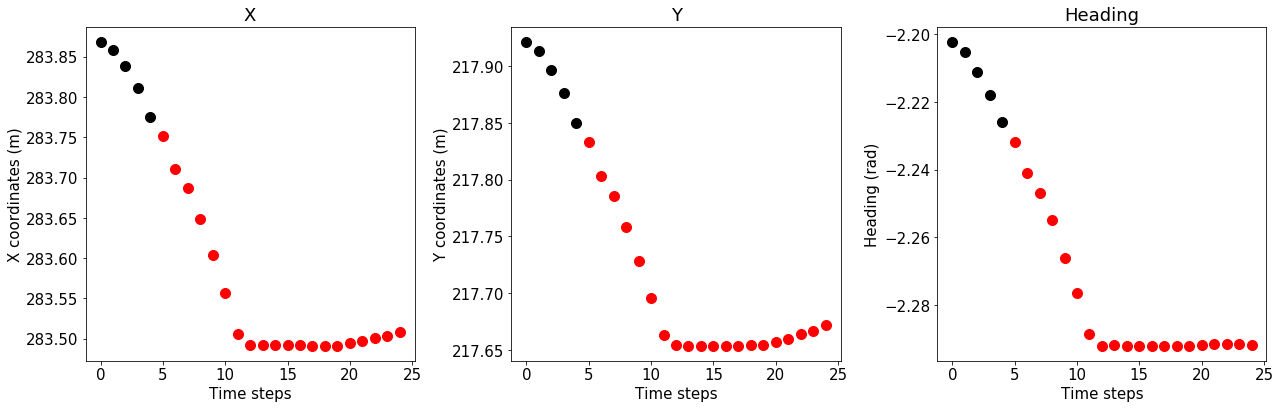

In [41]:
import matplotlib
features = pkl2tf_info[0]['features_global'][15]
labels = pkl2tf_info[0]['labels_global'][15]

Nhist = 5
Npred = 20

plt.figure(figsize=(18,6))

plt.subplot(131)
plt.plot(range(Nhist), features[:,0], 'ko', markersize=10)
plt.plot(range(Nhist, Nhist+Npred), labels[:,0], 'ro', markersize=10)
plt.ylabel('X coordinates (m)')
plt.xlabel('Time steps')
plt.title('X')

plt.subplot(132)
plt.plot(range(Nhist), features[:,1], 'ko', markersize=10)
plt.plot(range(Nhist, Nhist+Npred), labels[:,1], 'ro', markersize=10)
plt.ylabel('Y coordinates (m)')
plt.xlabel('Time steps')
plt.title('Y')

plt.subplot(133)
plt.plot(range(Nhist), features[:,2], 'ko', markersize=10)
plt.plot(range(Nhist, Nhist+Npred), labels[:,2], 'ro', markersize=10)
plt.ylabel('Heading (rad)')
plt.xlabel('Time steps')
plt.title('Heading')

font = {'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

plt.tight_layout()

In [ ]:
# Get the data
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 0

pklfile = pklfiles_to_process[file_num]

test_set  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}
test_set_kf  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

test_set['history_traj_data'], test_set['future_traj_data'], test_set['goal_position'], test_set['one_hot_goal'], traj_idx = extract_data(pklfile, full_traj=True, crop_traj=True)
test_set_kf['history_traj_data'], test_set_kf['future_traj_data'], test_set_kf['goal_position'], test_set_kf['one_hot_goal'], traj_idx_kf = extract_data(pklfile, full_traj=True, crop_traj=False)

In [ ]:
# Build the model
history_shape = test_set['history_traj_data'].shape
goals_position_shape = test_set['goal_position'].shape
one_hot_goal_shape = test_set['one_hot_goal'].shape
future_shape = test_set['future_traj_data'].shape
hidden_dim = 100
beta = 0.
gamma = 10.
use_goal_info = True
comb_lstm = CombinedLSTM(history_shape, goals_position_shape, one_hot_goal_shape, future_shape, hidden_dim, beta, gamma, use_goal_info)
# comb_lstm.load('file_name')
# comb_lstm.goal_model.load()
# comb_lstm.traj_model.load()

In [ ]:
comb_lstm.fit(test_set, test_set,verbose=1)

In [ ]:
comb_lstm.save('./model/test')

In [ ]:
#comb_lstm.load('./model/LSTM_h100_b1.000_fold0')
comb_lstm.load('./model/test')

In [ ]:
top_k_goal = [0, 1, 2]
goal_pred, traj_pred_dict = comb_lstm.predict(test_set, top_k_goal=top_k_goal)
print(traj_pred_dict[0].shape)

In [ ]:
kf = EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)

In [ ]:
kf.load('./model/EKF_CV_fold0.pkl')
goal_pred, traj_pred_dict = kf.predict(test_set_kf)

In [ ]:
sup_plot('test_lstm', test_set, traj_idx, goal_pred, traj_pred_dict, limit=2)

In [ ]:
# for i in range(len(traj_idx) - 1)

# Plot the result
goal_ind = np.arange(33)
bar_width = 0.35
# Recover the goal coordinates
test_goals_coords = test_set['goal_position'].reshape((test_set['goal_position'].shape[0], 32, 3))
test_hist_traj    = test_set['history_traj_data']
test_future_traj  = test_set['future_traj_data']
test_one_hot_goal = test_set['one_hot_goal']

for num_traj in range(2):
    
    print("Start processing trajectory # %03d ....." % num_traj)
    start_idx = traj_idx[num_traj]
    end_idx   = traj_idx[num_traj+1]
    directory = './figures/%03d' % num_traj
    if not os.path.exists(directory):
        os.mkdir(directory)

    for i in range(start_idx, end_idx):

        fig = plt.figure(dpi=200)
        plt.suptitle('LSTM', va='center')
        plt.subplot(211)

        vector = test_goals_coords[i][-3,:2] - test_goals_coords[i][-1,:2]
        th = np.arctan2(vector[1], vector[0])
        R = np.array([[ np.cos(th), np.sin(th)], \
                      [-np.sin(th), np.cos(th)]])

        # Plot the vehicle trajectory in the snippet
        test_hist_traj_rot = test_hist_traj[i][:,:2] @ R.T
        test_future_traj_rot = test_future_traj[i][:,:2] @ R.T
        plt.plot(test_hist_traj_rot[:,0], test_hist_traj_rot[:,1], 'k')
        plt.plot(test_future_traj_rot[:,0], test_future_traj_rot[:,1], color = '#1f77b4')
        
        probs = goal_pred[i].copy()
        prob_undetermined = probs[-1]
        probs.sort()
        for top_k, traj_pred in traj_pred_dict.items():
            traj_pred_rot      = traj_pred[i][:, :2] @ R.T
            prob = probs[-1-top_k]
            plt.plot(traj_pred_rot[:,0], traj_pred_rot[:,1], '.', markersize = 3, color = '#ff770e', alpha= prob)

        # Plot the occupancy in the snippet
        test_goals_coords_rot = test_goals_coords[i][:,:2] @ R.T
        for goal, occup in zip(test_goals_coords_rot, test_goals_coords[i]):
            if occup[2] > 0:
                plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
            else:
                plt.plot(goal[0], goal[1], 'ko', markersize = 9)

        # Get the ground truth intention
        gt_idx = np.argmax(test_one_hot_goal[i])
        # Predictions above a threshold
        thres = 1e-2
        
        best_k_idx = [np.argsort(goal_pred[i])[-1-k] for k in top_k_goal]
#         best_k_idx = [k for k, p in enumerate(goal_pred[i]) if p >= thres]
#         print(np.max(goal_pred[i]))
        if gt_idx == 32: # If it is "-1" -> undetermined 
            plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
        else:
            plt.plot(test_goals_coords_rot[gt_idx][0], test_goals_coords_rot[gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)

        for j in best_k_idx:
            if j == 32:
                plt.plot(0, 0, 'v', fillstyle='none', color = '#ff770e', markersize = 9, alpha=prob_undetermined)
            else:
                plt.plot(test_goals_coords_rot[j][0], test_goals_coords_rot[j][1], 'o', fillstyle='none', color = '#ff770e', markersize = 9)

        plt.title('Trajectory and Spots in Ego Frame')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
    #     plt.axis('equal')

        plt.subplot(212)
        p1 = plt.bar(goal_ind - bar_width/2, test_one_hot_goal[i], bar_width, label='GT')
        p2 = plt.bar(goal_ind + bar_width/2, goal_pred[i], bar_width, label='Pred')
        plt.xlabel('Goal Index')
        plt.ylabel('Probability')
        plt.title('Likelihood of Selecting Different Goals')
        plt.legend()
        plt.tight_layout()
        
        
        fig.savefig('./figures/%03d/frame_%03d.png' % (num_traj, i-start_idx))
        plt.close(fig)
        
    fps = 2
    mv = os.system("ffmpeg -r {0:d} -i ./figures/{1:03d}/frame_%03d.png -vcodec mpeg4 -y ./figures/{1:03d}_movie.mp4".format(fps, num_traj) )
    if mv == 0:
        print("Trajectory # %03d movie saved successfully." % num_traj)
    else:
        print("Meet problem saving Trajectory # %03d movie." % num_traj)